In [33]:
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image
from collections import Counter
#Importing tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB5, EfficientNetB3,EfficientNetB1, EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

For this I will be looking at the efficient Net models and comparing their performances

+ Let's start by creating important variables that we will use to create our train and validation generators

In [34]:
TRAIN_DATA_DIR="D:\Codes\Image-Classification\cardataset/train"
VALIDATION_DATA_DIR="D:\Codes\Image-Classification\cardataset/val"
TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES = 17
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

+ Generators are great ways to augment data and make the process very easy without using any local storage space.


In [35]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

+ Make the image fit the model input size so we don't have to do it one by one
+ Let's see the number of classes we have and the total number of images to get an idea of the dataset

In [36]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 22852 images belonging to 17 classes.
Found 5193 images belonging to 17 classes.


In [37]:
class_names=list((validation_generator.class_indices).keys())
class_names

['Ambulance',
 'Barge',
 'Bicycle',
 'Boat',
 'Bus',
 'Car',
 'Cart',
 'Caterpillar',
 'Helicopter',
 'Limousine',
 'Motorcycle',
 'Segway',
 'Snowmobile',
 'Tank',
 'Taxi',
 'Truck',
 'Van']

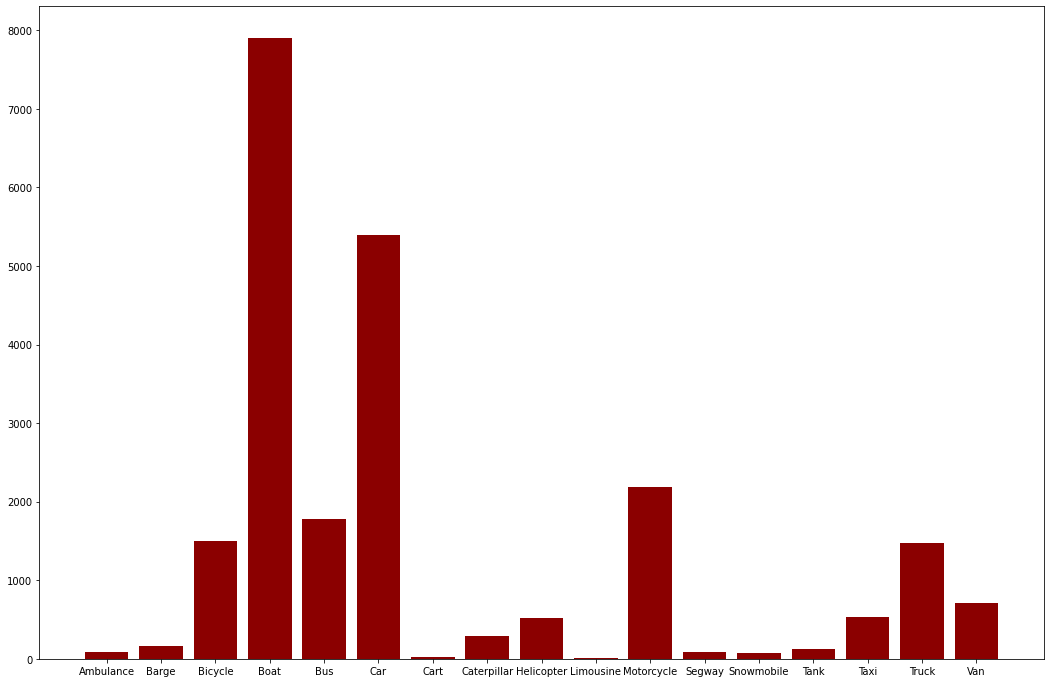

In [38]:
class_names=list((train_generator.class_indices).keys())
counter = Counter(train_generator.classes).values()
plt.figure(figsize=(18,12))
plt.bar(x=class_names,height=counter,color='darkred')
plt.show()

##### Create Model -> EfficientNet B5
+ In this we are using transfer learning techniques and so we first unfreeze the top layers and fine tune them according to our needs.
+ 

In [39]:
def model_maker(model=EfficientNetB5):
    base_model = model(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)
model_b5 = model_maker(model=EfficientNetB5)
model_b5.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb5 (Functional)  (None, 7, 7, 2048)       28513527  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 64)                131136    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 17)                1105      
                                                           

In [40]:
model_b5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])
hist_b5=model_b5.fit(
    train_generator,
    steps_per_epoch=math.ceil(18),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

Epoch 1/20
18/18 [==============================] - 31s 1s/step - loss: 1.7946 - acc: 0.5651 - val_loss: 1.0206 - val_acc: 0.7520
Epoch 2/20
18/18 [==============================] - 23s 1s/step - loss: 0.9165 - acc: 0.7639 - val_loss: 0.9517 - val_acc: 0.7852
Epoch 3/20
18/18 [==============================] - 23s 1s/step - loss: 0.7379 - acc: 0.7934 - val_loss: 0.8732 - val_acc: 0.7871
Epoch 4/20
18/18 [==============================] - 25s 1s/step - loss: 0.6272 - acc: 0.8316 - val_loss: 0.8099 - val_acc: 0.8203
Epoch 5/20
18/18 [==============================] - 34s 2s/step - loss: 0.5890 - acc: 0.8359 - val_loss: 0.7964 - val_acc: 0.8145
Epoch 6/20
18/18 [==============================] - 32s 2s/step - loss: 0.6254 - acc: 0.8359 - val_loss: 0.7239 - val_acc: 0.8184
Epoch 7/20
18/18 [==============================] - 30s 2s/step - loss: 0.5375 - acc: 0.8524 - val_loss: 0.7511 - val_acc: 0.7988
Epoch 8/20
18/18 [==============================] - 31s 2s/step - loss: 0.5857 - acc: 0.82

In [41]:
hist_df_B5 = pd.DataFrame(hist_b5.history)
model_b5.save('model_EfficientNetB5.h5')

C:\Users\shzso\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


#### Creating Model Efficientnet B3

In [42]:
model_b3 = model_maker(model=EfficientNetB3)
model_b3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_4   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 64)                98368     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 17)                1105      
                                                           

In [43]:

model_b3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])
hist_b3=model_b3.fit(
    train_generator,
    steps_per_epoch=math.ceil(18),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

Epoch 1/20
18/18 [==============================] - 33s 1s/step - loss: 1.8591 - acc: 0.5191 - val_loss: 1.2989 - val_acc: 0.7109
Epoch 2/20
18/18 [==============================] - 23s 1s/step - loss: 1.0593 - acc: 0.7205 - val_loss: 1.0511 - val_acc: 0.7539
Epoch 3/20
18/18 [==============================] - 23s 1s/step - loss: 0.8605 - acc: 0.7708 - val_loss: 0.9635 - val_acc: 0.7656
Epoch 4/20
18/18 [==============================] - 23s 1s/step - loss: 0.8004 - acc: 0.7752 - val_loss: 0.9876 - val_acc: 0.7578
Epoch 5/20
18/18 [==============================] - 23s 1s/step - loss: 0.7194 - acc: 0.8082 - val_loss: 0.9202 - val_acc: 0.7695
Epoch 6/20
18/18 [==============================] - 22s 1s/step - loss: 0.7074 - acc: 0.8064 - val_loss: 0.9051 - val_acc: 0.7676
Epoch 7/20
18/18 [==============================] - 23s 1s/step - loss: 0.6722 - acc: 0.8142 - val_loss: 0.8624 - val_acc: 0.7715
Epoch 8/20
18/18 [==============================] - 23s 1s/step - loss: 0.6716 - acc: 0.81

In [44]:
hist_df_B3 = pd.DataFrame(hist_b3.history) 
model_b3.save('model_EfficientNetB3.h5')

### Efficient net B0

In [45]:
model_b0 = model_maker(model=EfficientNetB0)
model_b0.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 64)                81984     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 17)                1105      
                                                           

In [46]:

model_b0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])
hist_b0=model_b0.fit(
    train_generator,
    steps_per_epoch=math.ceil(18),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

Epoch 1/20
18/18 [==============================] - 28s 1s/step - loss: 1.9866 - acc: 0.4800 - val_loss: 1.3800 - val_acc: 0.6836
Epoch 2/20
18/18 [==============================] - 23s 1s/step - loss: 1.1947 - acc: 0.6979 - val_loss: 1.2039 - val_acc: 0.7344
Epoch 3/20
18/18 [==============================] - 22s 1s/step - loss: 1.0315 - acc: 0.7266 - val_loss: 1.1078 - val_acc: 0.7422
Epoch 4/20
18/18 [==============================] - 21s 1s/step - loss: 0.9175 - acc: 0.7535 - val_loss: 1.0781 - val_acc: 0.7266
Epoch 5/20
18/18 [==============================] - 21s 1s/step - loss: 0.8678 - acc: 0.7622 - val_loss: 0.9936 - val_acc: 0.7363
Epoch 6/20
18/18 [==============================] - 22s 1s/step - loss: 0.8363 - acc: 0.7700 - val_loss: 0.9357 - val_acc: 0.7422
Epoch 7/20
18/18 [==============================] - 21s 1s/step - loss: 0.8128 - acc: 0.7760 - val_loss: 0.9291 - val_acc: 0.7422
Epoch 8/20
18/18 [==============================] - 21s 1s/step - loss: 0.7301 - acc: 0.79

In [47]:
hist_df_B0 = pd.DataFrame(hist_b0.history) 
model_b0.save('model_EfficientNetB0.h5')

##### Model Efficient Net B1

In [48]:
model_b1 = model_maker(model=EfficientNetB1)
model_b1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 64)                81984     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 17)                1105      
                                                           

In [49]:

model_b1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])
hist_b1=model_b1.fit(
    train_generator,
    steps_per_epoch=math.ceil(18),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

Epoch 1/20
18/18 [==============================] - 28s 1s/step - loss: 2.0134 - acc: 0.4549 - val_loss: 1.5095 - val_acc: 0.6504
Epoch 2/20
18/18 [==============================] - 21s 1s/step - loss: 1.2748 - acc: 0.6944 - val_loss: 1.3027 - val_acc: 0.7109
Epoch 3/20
18/18 [==============================] - 21s 1s/step - loss: 0.9254 - acc: 0.7543 - val_loss: 1.1886 - val_acc: 0.7461
Epoch 4/20
18/18 [==============================] - 21s 1s/step - loss: 0.8271 - acc: 0.7847 - val_loss: 1.1597 - val_acc: 0.7520
Epoch 5/20
18/18 [==============================] - 22s 1s/step - loss: 0.7394 - acc: 0.7995 - val_loss: 1.1288 - val_acc: 0.7480
Epoch 6/20
18/18 [==============================] - 22s 1s/step - loss: 0.7823 - acc: 0.7839 - val_loss: 1.0545 - val_acc: 0.7598
Epoch 7/20
18/18 [==============================] - 22s 1s/step - loss: 0.7442 - acc: 0.8108 - val_loss: 1.0334 - val_acc: 0.7422
Epoch 8/20
18/18 [==============================] - 21s 1s/step - loss: 0.6651 - acc: 0.82

In [50]:
hist_df_B1 = pd.DataFrame(hist_b1.history) 
model_b1.save('model_EfficientNetB1.h5')

In [51]:

model_b5= tf.keras.models.load_model("model_EfficientNetB5.h5")
model_b3 = tf.keras.models.load_model("model_EfficientNetB3.h5")

In [52]:
def predict_image(img_path, model):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224,224])
    img=preprocess_input(img)
    img= tf.cast(tf.expand_dims(img, axis=0), tf.int16)
    #  


    prediction=model.predict(img)



    pred_class=class_names[tf.argmax(prediction[0])]
    pred_prob=(tf.reduce_max(prediction)*100).numpy()
    return pred_class,pred_prob

In [53]:
img_path = "D:\Downloads\photo-1558981403-c5f9899a28bc.jpg" #bike
img_path = "D:\Downloads/60825.jpg" #helicopter

predict_image(img_path=img_path,model=model_b3)

('Helicopter', 99.8656)

In [54]:
predict_image(img_path=img_path,model=model_b5)

('Helicopter', 99.54254)

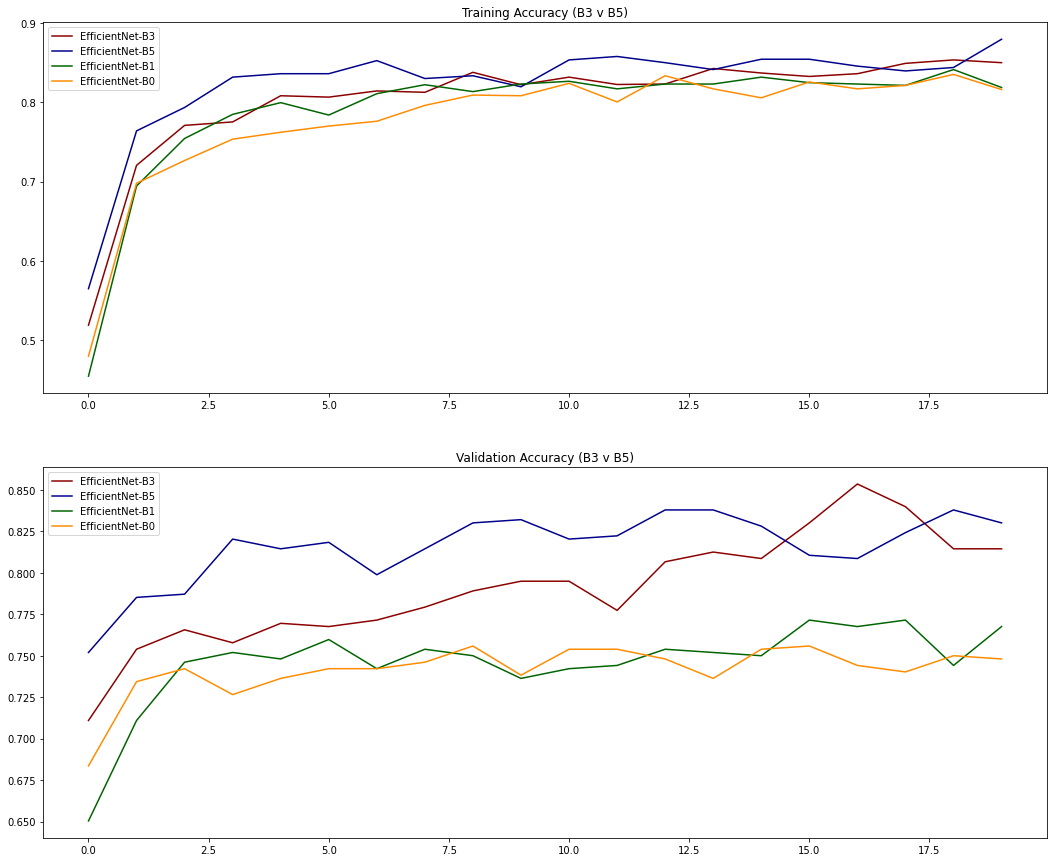

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(18,15))

ax1.plot(hist_df_B3.index,hist_df_B3['acc'],label='EfficientNet-B3',color='darkred')
ax1.plot(hist_df_B3.index,hist_df_B5['acc'],label='EfficientNet-B5',color='darkblue')
ax1.plot(hist_df_B3.index,hist_df_B1['acc'],label='EfficientNet-B1',color='darkgreen')
ax1.plot(hist_df_B3.index,hist_df_B0['acc'],label='EfficientNet-B0',color='darkorange')
ax1.legend()
ax1.title.set_text('Training Accuracy (B3 v B5)')

ax2.plot(hist_df_B3.index,hist_df_B3['val_acc'],label='EfficientNet-B3',color='darkred')
ax2.plot(hist_df_B3.index,hist_df_B5['val_acc'],label='EfficientNet-B5',color='darkblue')
ax2.plot(hist_df_B3.index,hist_df_B1['val_acc'],label='EfficientNet-B1',color='darkgreen')
ax2.plot(hist_df_B3.index,hist_df_B0['val_acc'],label='EfficientNet-B0',color='darkorange')
ax2.legend()
ax2.title.set_text('Validation Accuracy (B3 v B5)')

In [59]:
### Best classified images v Worst classified images

filenames = validation_generator.filenames
print(len(filenames))

ground_truth = validation_generator.classes
print(ground_truth[:10])
print(len(ground_truth))

5193
[0 0 0 0 0 0 0 0 0 0]
5193


In [60]:
label_to_index = validation_generator.class_indices
print(label_to_index)

{'Ambulance': 0, 'Barge': 1, 'Bicycle': 2, 'Boat': 3, 'Bus': 4, 'Car': 5, 'Cart': 6, 'Caterpillar': 7, 'Helicopter': 8, 'Limousine': 9, 'Motorcycle': 10, 'Segway': 11, 'Snowmobile': 12, 'Tank': 13, 'Taxi': 14, 'Truck': 15, 'Van': 16}


In [61]:
# Make an opposite dictionary with keys as values and values as keys
index_to_label = dict((v, k) for k, v in label_to_index.items())
print(index_to_label)

{0: 'Ambulance', 1: 'Barge', 2: 'Bicycle', 3: 'Boat', 4: 'Bus', 5: 'Car', 6: 'Cart', 7: 'Caterpillar', 8: 'Helicopter', 9: 'Limousine', 10: 'Motorcycle', 11: 'Segway', 12: 'Snowmobile', 13: 'Tank', 14: 'Taxi', 15: 'Truck', 16: 'Van'}


In [65]:
predictions = model_b0.predict_generator(validation_generator,
                                      steps=None)

print(predictions[:10])

C:\Users\shzso\AppData\Local\Temp\ipykernel_21616\1898106771.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_b0.predict_generator(validation_generator,


[[3.01444441e-01 1.93655444e-03 2.70525482e-03 1.17348218e-02
  1.29285082e-02 9.18838475e-03 7.90609419e-03 1.00452518e-02
  3.37535050e-03 1.34248589e-03 1.83430267e-03 9.88093088e-04
  1.89950573e-03 6.37360895e-03 1.76084321e-02 3.93883765e-01
  2.14805126e-01]
 [2.32872427e-01 1.26231601e-03 1.85704313e-03 9.06105898e-03
  5.53765744e-02 5.04453517e-02 4.98086726e-03 4.05264413e-03
  2.25094706e-03 1.04224926e-03 1.75229402e-03 4.35532856e-04
  7.02832243e-04 3.34199681e-03 5.38436919e-02 8.45108107e-02
  4.92211312e-01]
 [2.54293680e-01 4.64897836e-04 1.04975875e-03 8.19950830e-03
  1.43753499e-01 1.31161585e-02 2.61404319e-03 1.12991838e-03
  7.47879967e-04 3.57088196e-04 9.64894716e-04 1.10951354e-04
  1.90529405e-04 9.50677204e-04 1.21324249e-02 7.17993304e-02
  4.88124788e-01]
 [2.79307991e-01 7.69791310e-04 1.55648415e-03 5.03845373e-03
  1.82487015e-02 2.59025190e-02 4.13764920e-03 3.23416060e-03
  2.51758657e-03 7.23223726e-04 2.07769149e-03 2.92064477e-04
  6.45978609e-04

+ For each image, the model gives us the probability values that the iamge belongs to class x. We can use the argmax function to find the best class

In [76]:
prediction_table = {}
for index, val in enumerate(predictions):
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [
        value_of_highest_probability, index_of_highest_probability,
        ground_truth[index]
    ]
assert len(predictions) == len(ground_truth) == len(prediction_table)

In [93]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]


def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(int(len(images) / columns + 1), columns, int(i + 1))
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(VALIDATION_DATA_DIR +'/'+ filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)



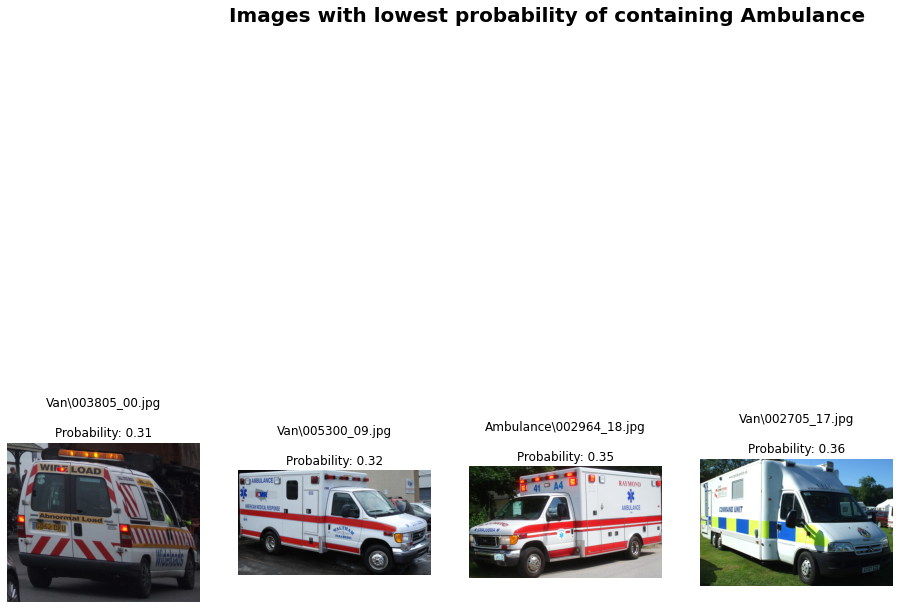

<Figure size 1440x1080 with 0 Axes>

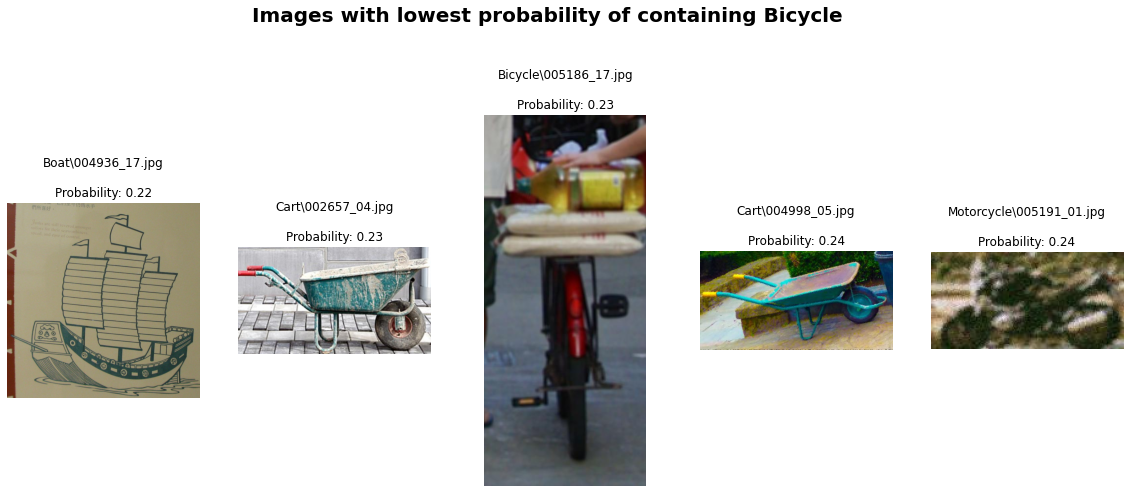

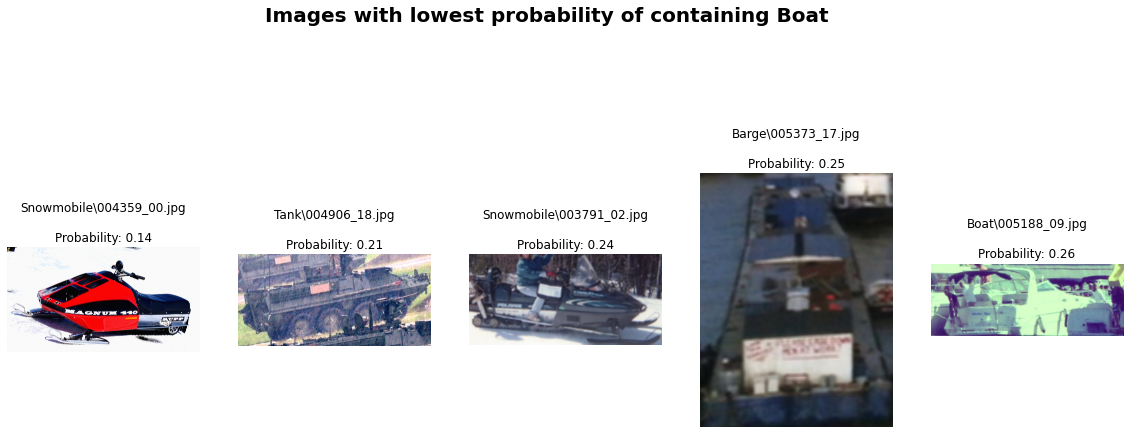

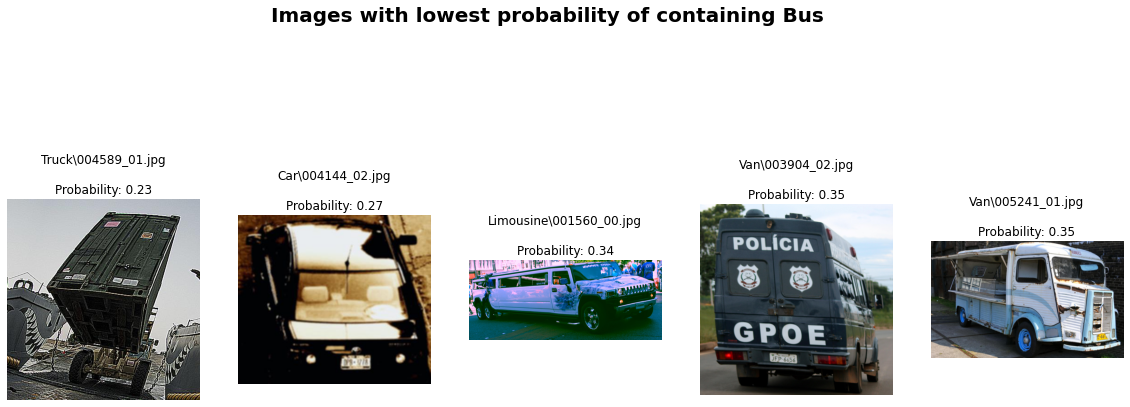

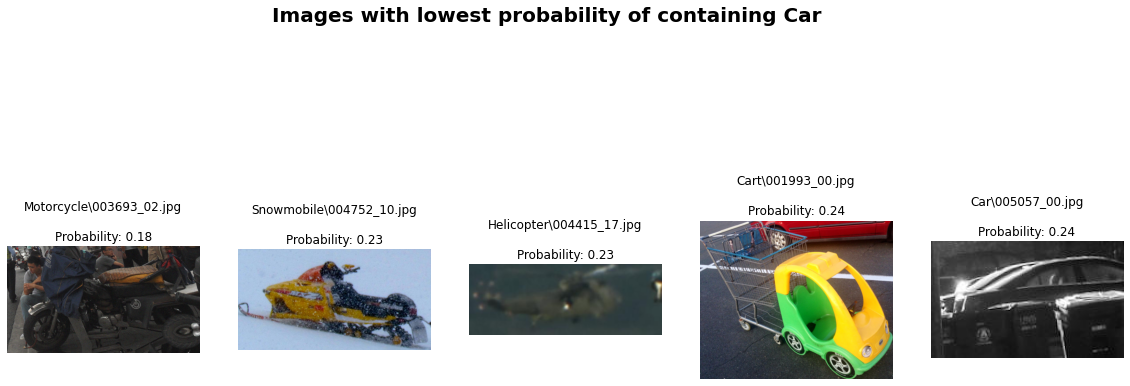

<Figure size 1440x1080 with 0 Axes>

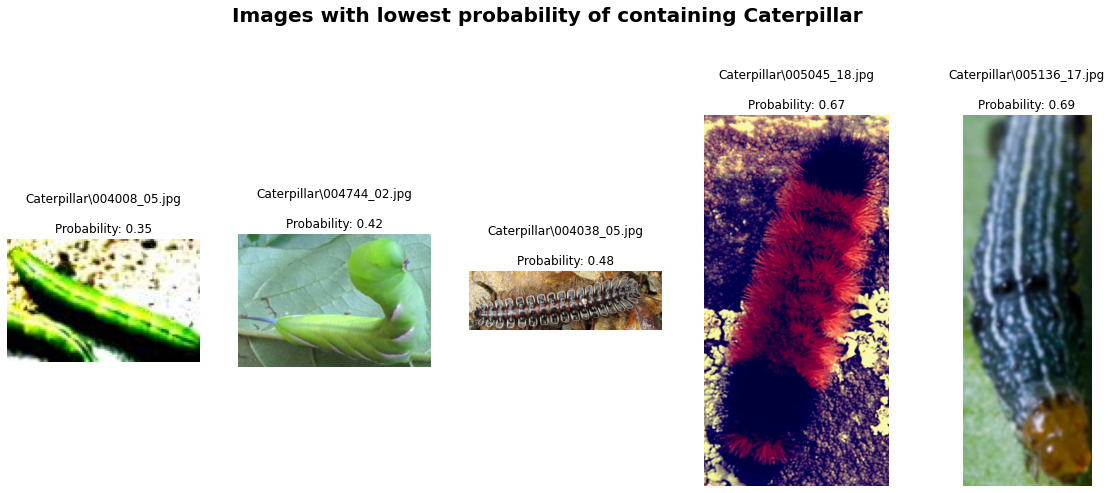

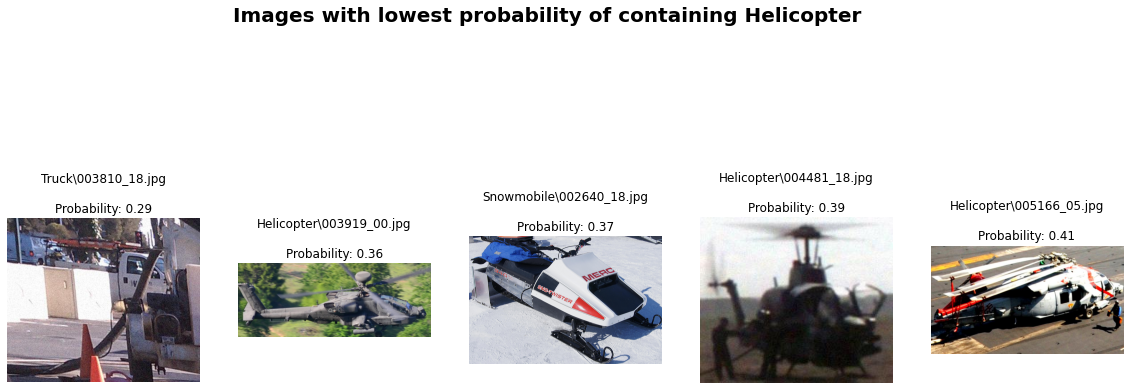

<Figure size 1440x1080 with 0 Axes>

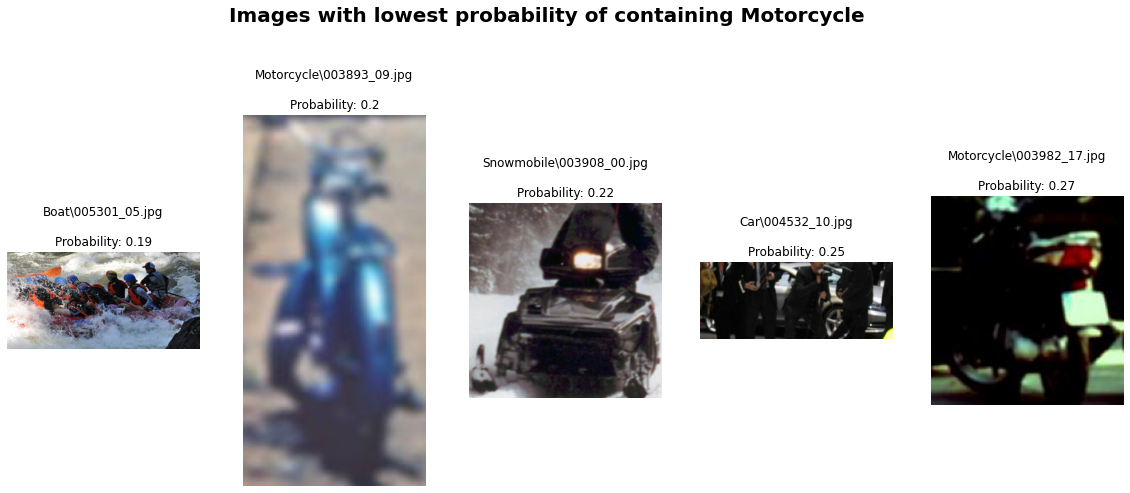

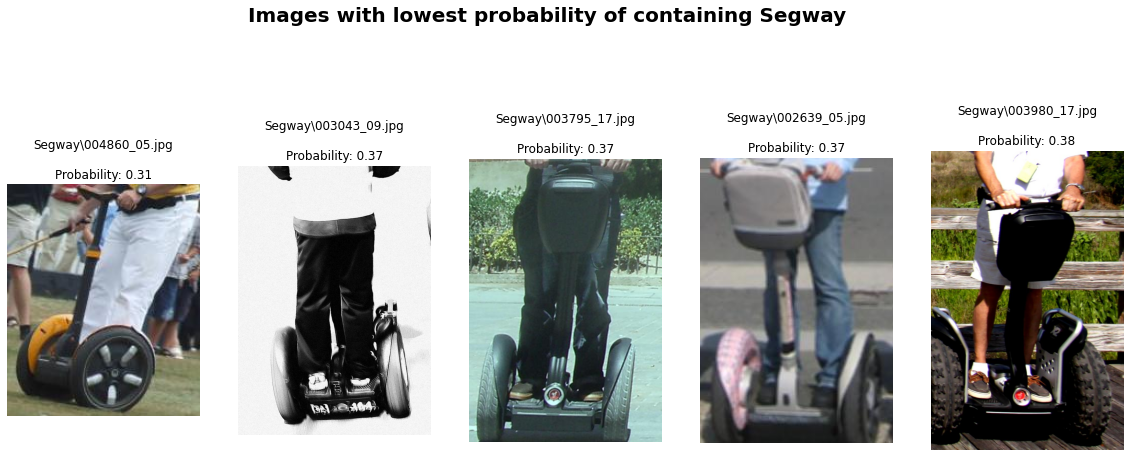

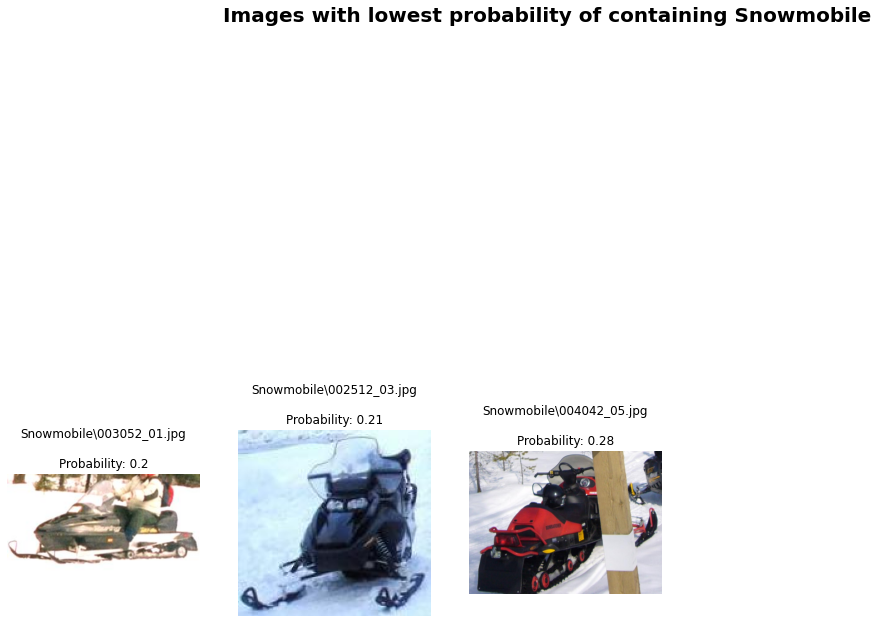

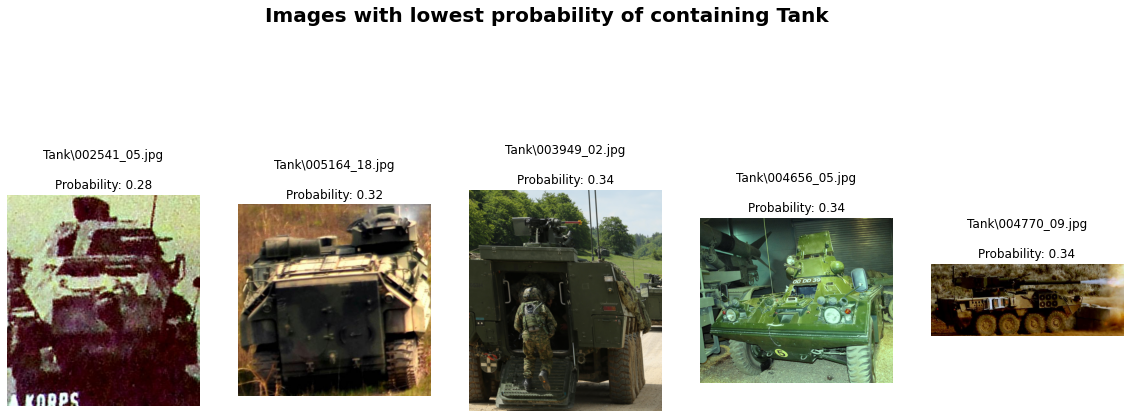

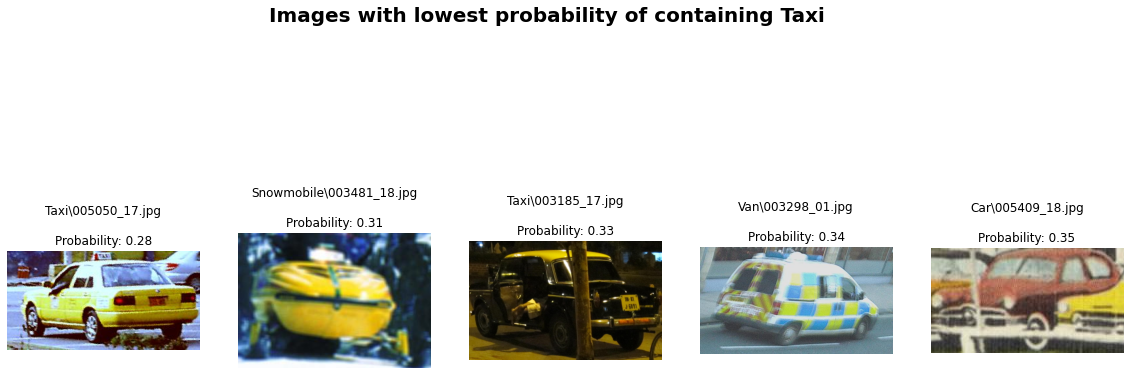

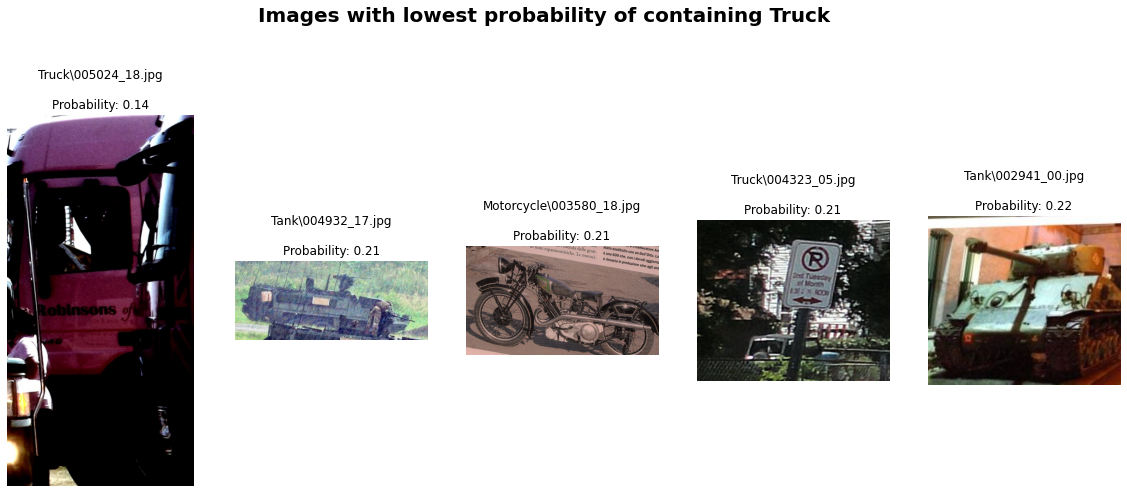

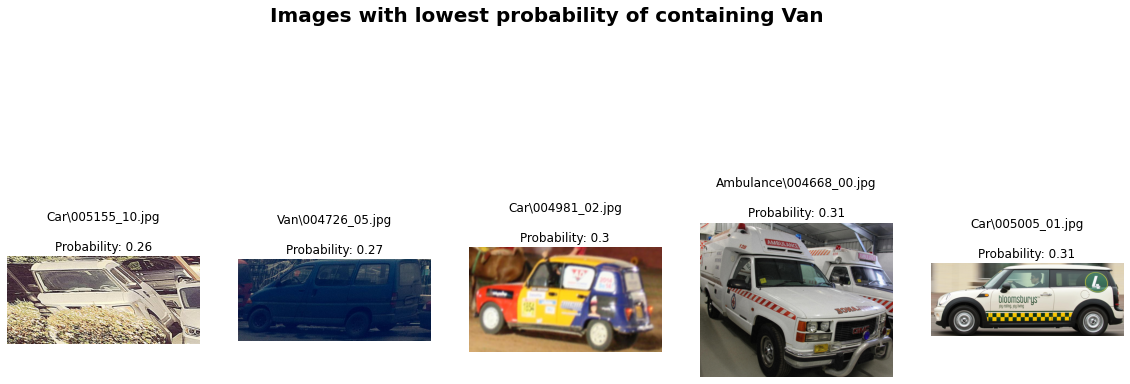

In [107]:
for index,label in enumerate(validation_generator.class_indices):
    # print(index,label)
    least_confident_images = get_images_with_sorted_probabilities(prediction_table, False, index, 5,
                                                False)
    message = f'Images with lowest probability of containing {label}'
    display(least_confident_images, message)       